# 🎮 Case Study: EDA & Datacleaning op de *Steam Video Games* dataset

Deze notebook doorloopt een **end-to-end verkenning (EDA)** en **datacleaning** van een gaming dataset (Steam).

## Probleemstelling
We willen een goed beeld krijgen van het aanbod op Steam: welke genres en categorieën zijn populair, hoe evolueert het aanbod in de tijd, en hoe verhouden prijs en (een maat voor) populariteit zich tot elkaar? Daarnaast willen we datakwaliteit verbeteren door missende waarden, ongeldige waarden en onjuiste datatypes aan te pakken.

Concreet beantwoorden we o.a. de volgende vragen:

1. **Datakwaliteit & structuur**
   - Welke kolommen zijn aanwezig? Welke datatypes horen daarbij?
   - Hoeveel missende waarden zijn er en waar?
   - Zijn er dubbele rijen of inconsistenties (bv. datums, prijzen)?

2. **Samenstelling van het aanbod**
   - Hoe is de verdeling over **genres** en **categories**?
   - Welke **developers** en **publishers** brengen het meeste uit?
   - Hoe evolueert het aantal releases **per jaar**?

3. **Prijs en populariteit**
   - Wat is de verdeling van **prijzen**?
   - Bestaat er een relatie tussen **prijs** en een maat voor **populariteit** (bv. *owners*, *recommendations*, *playtime*, afhankelijk van wat beschikbaar is)?

4. **Regio’s / leeftijd / tags** (optioneel, afhankelijk van dataset)
   - Hoe verhouden **leeftijdsvereisten** (required_age) of tags zich tot populariteit/prijs?

Tot slot genereren we een **automatisch EDA-rapport** met *Sweetviz* als aanvulling op onze handmatige verkenning.


## 🔧 Setup

**Benodigdheden**:
- `pandas`, `numpy`, `matplotlib`, `seaborn`
- *Voor automatische download*: `kagglehub`
- *EDA-rapport*: `sweetviz`

⚠️ **Sweetviz & NumPy**: sommige Sweetviz-versies zijn (nog) niet volledig compatibel met `numpy>=2`. Als je een fout krijgt over `VisibleDeprecationWarning`, patch het tijdelijk (zie verder).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

import re

## 📥 Data inladen
We gaan eerst de dataset via **KaggleHub** op te halen: `nikdavis/steam-store-games`.
Enkel de csv met naam steam.csv moet ingeladen worden.

In [3]:
DATASET = "nikdavis/steam-store-games"  # Kaggle dataset slug

path = kagglehub.dataset_download(DATASET)
df_raw = pd.read_csv(f"{path}/steam.csv")

100%|██████████| 35.2M/35.2M [00:01<00:00, 26.2MB/s]


Extracting files...


In [5]:
df = df_raw.copy()
df.tail()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19
27074,1069460,Rune Lord,2019-04-24,1,Adept Studios GD,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,4,0,0,0,0-20000,5.19


## 🧹 Eerste cleaning & verkenning
We bekijken rijen/kolommen, datatypes, missende waarden en dubbels.

In [8]:
df.shape
df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27074 non-null  object 
 5   publisher         27061 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

In [10]:
df.isna().sum().sort_values(ascending=False)

publisher           14
developer            1
name                 0
appid                0
english              0
release_date         0
platforms            0
required_age         0
categories           0
genres               0
steamspy_tags        0
achievements         0
positive_ratings     0
negative_ratings     0
average_playtime     0
median_playtime      0
owners               0
price                0
dtype: int64

In [13]:
df.duplicated().sum()
# er zijn 0 duplicaten. als er toch zijn
df = df.drop_duplicates()

### Datatype fixes (afhankelijk van beschikbare kolommen)
We proberen enkele veelvoorkomende kolommen te normaliseren: 

* `release_date` → Zet het om naar een datetime. Voeg ook een kolom release_year toe dat enkel het jaar bevat
* `price` →  Hou enkel cijfers (en '.' als decimaal teken) over en verwijder komma's en speciale symbolen. Rond af op twee cijfers na de komma
* `owners` → Is momenteel tekst in de vorm van "min-max", pas het aan naar een numerieke waarde midden van het bereik
* `genres/categories` → momenteel tekst met genres/categorieen gesplitst door ';'. Pas het aan naar python-lijsten

In [16]:
# release_date
df.release_date = pd.to_datetime(df.release_date, errors='coerce')
df['release_year'] = df.release_date.dt.year
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,release_year
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,2000
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99,1999
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99,2003
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99,2001
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99,1999


In [19]:
def to_price(x):
    x = str(x) # dit is een indicatie dat het eigenlijk overbodig is maar ik had het gevraagd als oefening
    x = x.replace(',', '.')
    x = re.sub(r"[^0-9.]+", "", x) # r"" is een reguliere expressie -> hou enkel over cijfers tussen 0 en 9 en . en er moet minstens 1 zijn
    return float(x)

df.price = df.price.apply(to_price)
df.price.head()

0    7.19
1    3.99
2    3.99
3    3.99
4    3.99
Name: price, dtype: float64

In [21]:
# owners naar het midden van de range
def owners_midpoint(x):
    values = x.split('-')
    low = int(values[0])
    high = int(values[1])
    return (low+high)/2

df.owners = df.owners.apply(owners_midpoint)
df.owners.head()

0    15000000.0
1     7500000.0
2     7500000.0
3     7500000.0
4     7500000.0
Name: owners, dtype: float64

In [25]:
df.genres = df.genres.str.split(';')
df.categories = df.categories.str.split(';')

## ❓ Vragen & analyses
### V1. Hoe ziet de verdeling van genres eruit?
We tellen frequenties van genres (als de kolom aanwezig is).

In [30]:
display(df.genres) # kijk naar de laatste waarde (27074): er zijn drie genres. 
display(df.genres.explode()) # na de explode zijn er drie rijen
df.genres.explode().value_counts()

0                          [Action]
1                          [Action]
2                          [Action]
3                          [Action]
4                          [Action]
                    ...            
27070    [Adventure, Casual, Indie]
27071    [Action, Adventure, Indie]
27072       [Action, Casual, Indie]
27073    [Adventure, Casual, Indie]
27074    [Adventure, Casual, Indie]
Name: genres, Length: 27075, dtype: object

0           Action
1           Action
2           Action
3           Action
4           Action
           ...    
27073       Casual
27073        Indie
27074    Adventure
27074       Casual
27074        Indie
Name: genres, Length: 76462, dtype: object

genres
Indie                    19421
Action                   11903
Casual                   10210
Adventure                10032
Strategy                  5247
Simulation                5194
RPG                       4311
Early Access              2954
Free to Play              1704
Sports                    1322
Racing                    1024
Violent                    843
Massively Multiplayer      723
Gore                       537
Nudity                     266
Sexual Content             245
Utilities                  146
Design & Illustration       87
Animation & Modeling        79
Education                   51
Video Production            38
Software Training           31
Audio Production            29
Web Publishing              28
Game Development            17
Photo Editing               12
Accounting                   6
Documentary                  1
Tutorial                     1
Name: count, dtype: int64

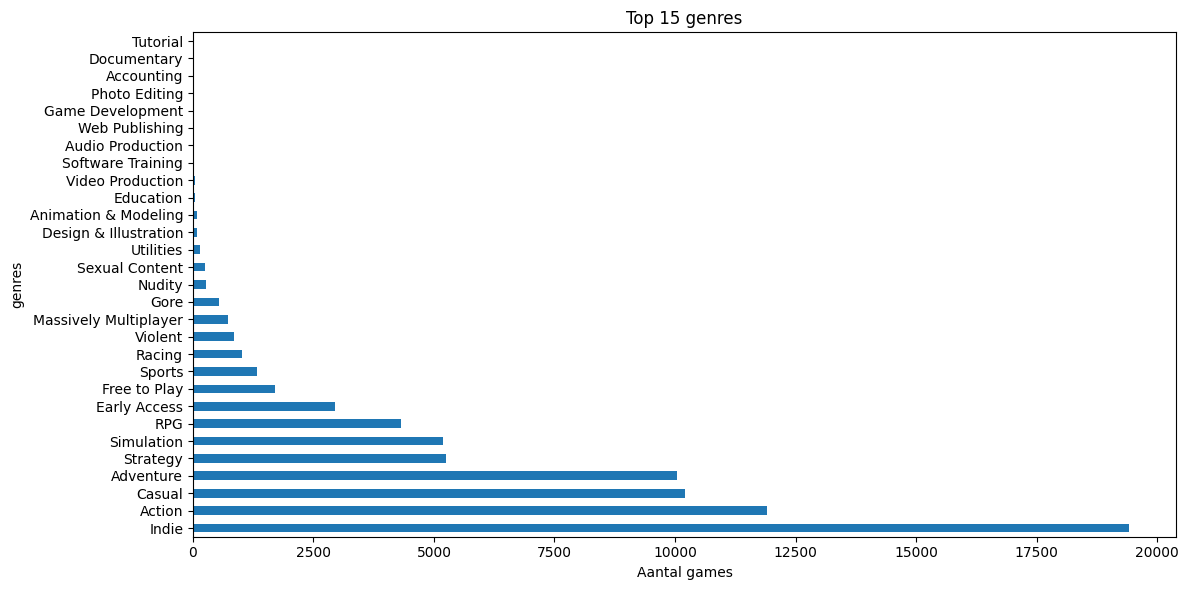

In [31]:
plt.figure(figsize=(12,6))
df.genres.explode().value_counts().plot.barh()
plt.title("Top 15 genres")
plt.xlabel("Aantal games")
plt.tight_layout()
plt.show()

### V2. Hoe evolueert het aantal releases per jaar?

In [32]:
df.groupby('release_year').size()

release_year
1997       1
1998       1
1999       2
2000       2
2001       4
2002       1
2003       3
2004       6
2005       6
2006      48
2007      93
2008     145
2009     305
2010     238
2011     239
2012     320
2013     418
2014    1555
2015    2597
2016    4361
2017    6357
2018    8160
2019    2213
dtype: int64

### V3. Wat is de verdeling van prijzen? (indien beschikbaar)

<Axes: >

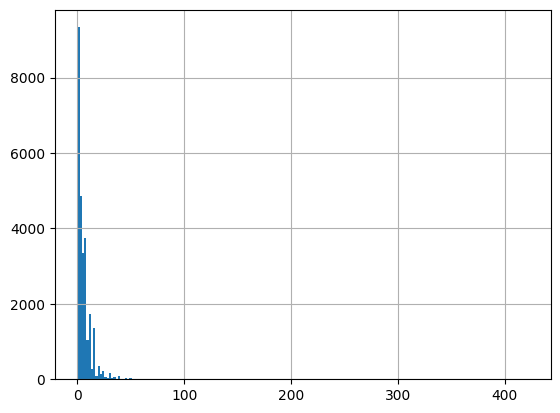

In [34]:
df.price.hist(bins=200)

### V4. Relatie tussen prijs en populariteit
We proberen een scatterplot *prijs vs populariteit* te maken. Populariteit meten we met wat beschikbaar is: `owners` (midpoint), `recommendations`, `positive_ratings`, `average_playtime`, ...

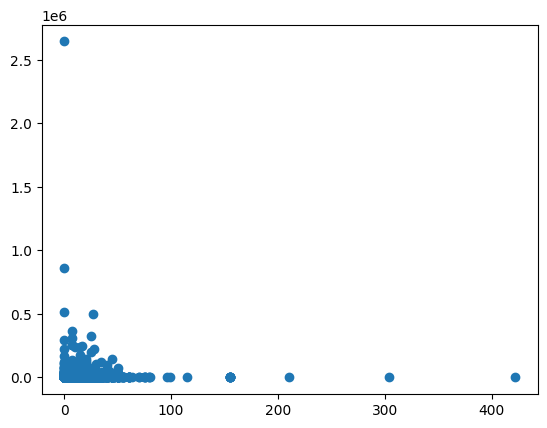

In [36]:
plt.scatter(df.price, df.positive_ratings)

### V5. Top developers/publishers (aantal titels en (optioneel) gemiddelde populariteit)

In [39]:
df.developer.value_counts().head(15)

developer
Choice of Games               94
KOEI TECMO GAMES CO., LTD.    72
Ripknot Systems               62
Laush Dmitriy Sergeevich      51
Nikita "Ghost_RUS"            50
Dexion Games                  45
RewindApp                     43
Hosted Games                  42
Blender Games                 40
For Kids                      36
Humongous Entertainment       36
EnsenaSoft                    35
Nekyau Games                  32
Eipix Entertainment           32
Warfare Studios               31
Name: count, dtype: int64

## 🧪 Train/Test splits voor vergelijkende EDA (optioneel)

## 📗 Sweetviz-rapport genereren
Als je een fout krijgt over `numpy.VisibleDeprecationWarning`, gebruik tijdelijk `numpy<2.0` **of** de *monkey patch* hieronder.

## 📌 Samenvatting & vervolgstappen
- We hebben de dataset opgeschoond (datatypes, missende waarden, eenvoudige parsers) en eerste inzichten verkregen in **genres**, **tijdsevolutie**, **prijzen** en **populariteit**.
- Voor verdere analyse kun je:
  - Geavanceerdere feature-engineering doen (bijv. *tags* one-hot encoden, *owners* log-transformeren).
  - Meer robuuste outlier-detectie (IQR/mad) toepassen op prijs en speeltijd.
  - Een eenvoudig model bouwen om populariteit te voorspellen op basis van metadata (genre, developer, release_year, prijs).
